# Autoencoders: Image Denoising (MNIST)

We are going to work with the MNIST dataset: handwritten numbers from 0-9 in images with 28x28 pixels.

In this notebook, two autoencoders are built:

1. An **autoencoder that re-creates the input image in the output**. By taking only the encoder part we could apply **dimensionality reduction** with a 2-neurons middle layer; then, we would transform the 28x28 images to 2D datapoints. That way, similarly to PCA (Principal Component Analysis), we could plot the datapoints and see how close they are from one another and whether/where they overlap.

2. An autoencoder which showcases how **denoising** is possible:
- We take the complete MNIST dataset
- We apply noise to the images
- We build and autoencoder which
    - Takes the noisy image and expected the original image without noise
    - We train it
    - During inference
        - the model takes a nooisy image
        - it compresses it with the encoder
        - it expands it with the decoder to be denoised!

## 1. Dimensionality Reduction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.datasets import mnist

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

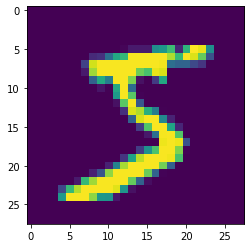

In [6]:
plt.imshow(X_train[0])

In [7]:
# Scale
X_train = X_train/255
X_test = X_test/255

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Reshape
from tensorflow.keras.optimizers import SGD

### Model

There is no fixed way of defining the encoder and the decoder.
A possible approach is to halven the number of values step by step:

`28x28 = 784 -> 400 -> 200 -> 100 -> 50 -> 25`

At the end, we compress to around 3% of the total values.

In [14]:
X_train.shape

(60000, 28, 28)

In [27]:
# Encoder: we compress by halving
encoder = Sequential()
# First, we flatten the image
encoder.add(Flatten(input_shape=[28,28]))
encoder.add(Dense(units=400,activation='relu'))
encoder.add(Dense(units=200,activation='relu'))
encoder.add(Dense(units=100,activation='relu'))
encoder.add(Dense(units=50,activation='relu'))
encoder.add(Dense(units=25,activation='relu'))

In [28]:
# Decoder: we expand by doubling
decoder = Sequential()
decoder.add(Dense(50,input_shape=[25],activation='relu'))
decoder.add(Dense(100,activation='relu'))
decoder.add(Dense(200,activation='relu'))
decoder.add(Dense(400,activation='relu'))
# Important to change it to be a sigmoid, which maps values to [0,1]
decoder.add(Dense(784,activation='sigmoid'))
# Important to reshape it to compare with the original images
decoder.add(Reshape([28,28]))

In [29]:
# Autoencoder
autoencoder = Sequential([encoder,decoder])

In [30]:
# We use the BINARY cross-entropy loss
# because we want to know whether the input and output images are equivalent
autoencoder.compile(loss='binary_crossentropy',
                   optimizer=SGD(lr=1.5),
                   metrics=['accuracy'])

In [31]:
# Train!
autoencoder.fit(X_train,X_train,
               epochs=5,
               validation_data=[X_test,X_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 29s 485us/sample - loss: 0.2476 - accuracy: 0.7912 - val_loss: 0.2002 - val_accuracy: 0.7948
Epoch 2/5
60000/60000 [==============================] - 28s 462us/sample - loss: 0.1820 - accuracy: 0.7979 - val_loss: 0.1620 - val_accuracy: 0.8010
Epoch 3/5
60000/60000 [==============================] - 28s 472us/sample - loss: 0.1570 - accuracy: 0.8025 - val_loss: 0.1509 - val_accuracy: 0.8045
Epoch 4/5
60000/60000 [==============================] - 29s 480us/sample - loss: 0.1463 - accuracy: 0.8044 - val_loss: 0.1416 - val_accuracy: 0.8048
Epoch 5/5
60000/60000 [==============================] - 28s 474us/sample - loss: 0.1410 - accuracy: 0.8053 - val_loss: 0.1382 - val_accuracy: 0.8049


In [32]:
# Inference
passed_images = autoencoder.predict(X_test[:10])

Original image


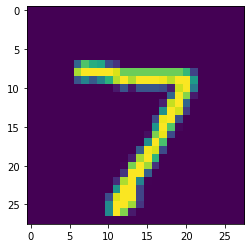

Reconstruction by Autoencoder


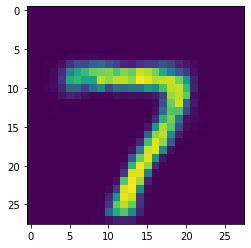

In [48]:
# Plot/Display
# We get very impressive results: we managed to create a NN
# that compresses an MNIST image to 3% of its size
# and that is able to reproduce a very similar image from the compressed one
n = 0
print("Original image")
plt.imshow(X_test[n])
plt.show()
print("Reconstruction by Autoencoder")
plt.imshow(passed_images[n])
plt.show()

## 2. Denoising

We are going to add noise to our images and then remove it.
There are multiple ways of adding noise to an image, but we're going to use Tensorflow for that.

In [49]:
from tensorflow.keras.layers import GaussianNoise

In [50]:
sample = GaussianNoise(stddev=0.2)

In [53]:
# We add noise
noisey = sample(X_test[:10],training=True)

Original image


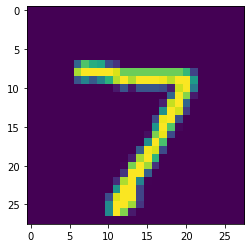

Noisey


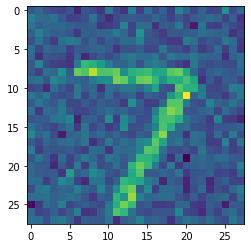

In [54]:
# Plot/Display
n = 0
print("Original image")
plt.imshow(X_test[n])
plt.show()
print("Noisey")
plt.imshow(noisey[n])
plt.show()

### Model

We use the same model as before; however, we add the GaussianNoise() layer at the beginning of the encoder

In [60]:
# Define a seed to control the random numbers
import tensorflow as tf
tf.random.set_seed(101)
np.random.seed(101)

In [61]:
# Encoder: we compress by halving
encoder = Sequential()
# First, we flatten the image
encoder.add(Flatten(input_shape=[28,28]))
# Then, we addd noise
encoder.add(GaussianNoise(0.2))
# After that, the compressing starts
encoder.add(Dense(units=400,activation='relu'))
encoder.add(Dense(units=200,activation='relu'))
encoder.add(Dense(units=100,activation='relu'))
encoder.add(Dense(units=50,activation='relu'))
encoder.add(Dense(units=25,activation='relu'))

In [62]:
# Decoder: we expand by doubling
decoder = Sequential()
decoder.add(Dense(50,input_shape=[25],activation='relu'))
decoder.add(Dense(100,activation='relu'))
decoder.add(Dense(200,activation='relu'))
decoder.add(Dense(400,activation='relu'))
# Important to change it to be a sigmoid, which maps values to [0,1]
decoder.add(Dense(784,activation='sigmoid'))
# Important to reshape it to compare with the original images
decoder.add(Reshape([28,28]))

In [63]:
noise_remover = Sequential([encoder,decoder])

In [64]:
noise_remover.compile(loss='binary_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

In [65]:
noise_remover.fit(X_train,X_train,epochs=8)

Train on 60000 samples
Epoch 1/8
60000/60000 [==============================] - 39s 652us/sample - loss: 0.1720 - accuracy: 0.8009
Epoch 2/8
60000/60000 [==============================] - 39s 643us/sample - loss: 0.1303 - accuracy: 0.8078
Epoch 3/8
60000/60000 [==============================] - 38s 642us/sample - loss: 0.1217 - accuracy: 0.8094
Epoch 4/8
60000/60000 [==============================] - 38s 634us/sample - loss: 0.1157 - accuracy: 0.8104
Epoch 5/8
60000/60000 [==============================] - 40s 675us/sample - loss: 0.1114 - accuracy: 0.8111
Epoch 6/8
60000/60000 [==============================] - 38s 626us/sample - loss: 0.1084 - accuracy: 0.8116
Epoch 7/8
60000/60000 [==============================] - 37s 616us/sample - loss: 0.1063 - accuracy: 0.8119
Epoch 8/8
60000/60000 [==============================] - 38s 628us/sample - loss: 0.1047 - accuracy: 0.8121


In [70]:
# Add noise
ten_noisey_images = sample(X_test[:10],training=True)

In [71]:
# Inference
denoised = noise_remover(ten_noisey_images)

Original


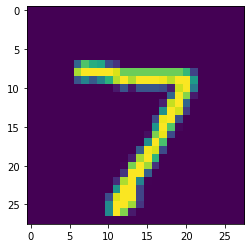

Noise added (once)


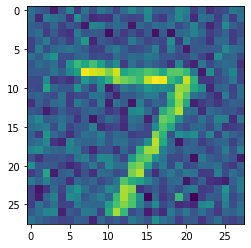

After noise removal (2x noise added!)


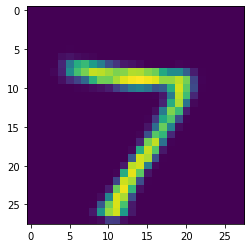

In [76]:
# Plot
n = 0
print("Original")
plt.imshow(X_test[n])
plt.show()
print("Noise added (once)")
plt.imshow(ten_noisey_images[n])
plt.show()
print("After noise removal (2x noise added!)")
# IMPORTANT note: we are adding noise twice!!
plt.imshow(denoised[n])
plt.show()